In [129]:
#perform imports, set display size for images.
import numpy as np
import numpy.linalg as linalg
%matplotlib inline
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

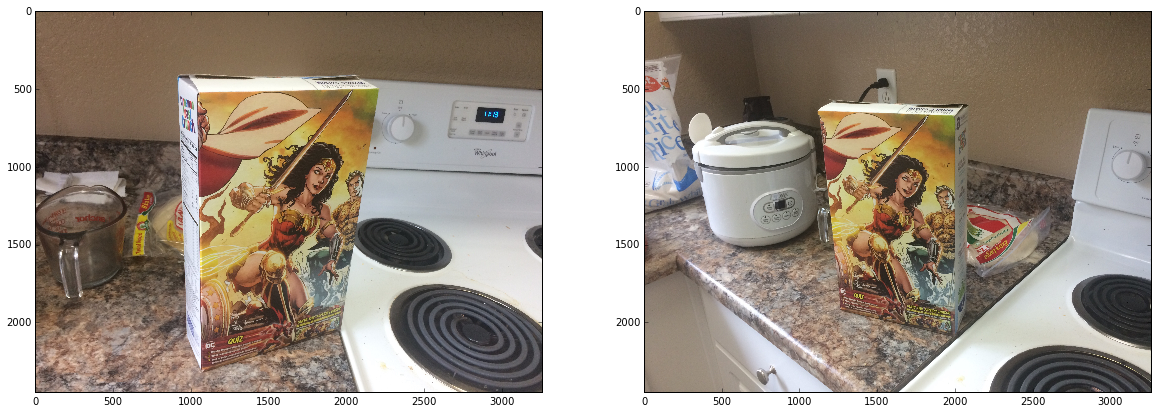

In [130]:
#read in and display images
road1 = cv2.imread("hw1data/190HW1.png")
road2 = cv2.imread("hw1data/190HW2.png")
road1 = cv2.cvtColor(road1, cv2.COLOR_BGR2RGB)
road2 = cv2.cvtColor(road2, cv2.COLOR_BGR2RGB)
plt.subplot(121)
plt.imshow(road1)
plt.subplot(122)
plt.imshow(road2)

In [131]:
#generate keypoints and their descriptors, as described in OpenCV guide for SIFT.
road1gray = cv2.cvtColor(road1, cv2.COLOR_RGB2GRAY)
road2gray = cv2.cvtColor(road2, cv2.COLOR_RGB2GRAY)
sift = cv2.xfeatures2d.SIFT_create()
keypoints1, des1 = sift.detectAndCompute(road1gray,None)
keypoints2, des2 = sift.detectAndCompute(road2gray,None)
road1 = cv2.drawKeypoints(road1gray, keypoints1, road1)
#cv2.imwrite('sift_keypoints_road1.png', road1)
road2 = cv2.drawKeypoints(road2gray, keypoints2, road2)
#cv2.imwrite('sift_keypoints_road2.png', road2)

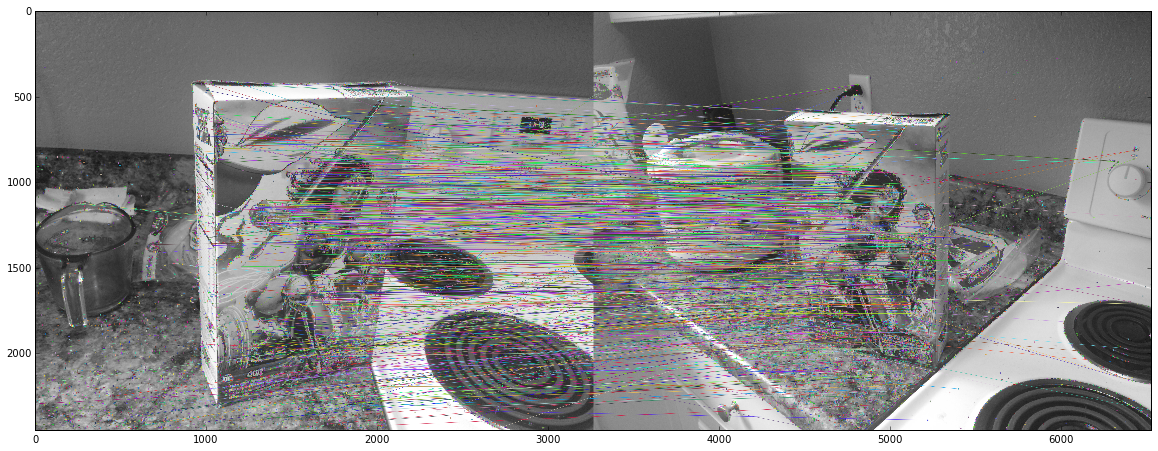

In [132]:
#find and plot matches
matcher = cv2.BFMatcher()
matches = matcher.knnMatch(des1, des2, k=2)
#perform ratio test to remove ambigous points as suggested in OpenCV guide
good = []
for m, n in matches:
    if m.distance < .75*n.distance:
        good.append([m])
#draw the matches
matchImg = cv2.drawMatchesKnn(road1, keypoints1, road2, keypoints2, good, None, flags=2)
plt.imshow(matchImg)

In [133]:
# estimate fundamental matrix using function from part B, slightly modified for keypoints
def computeF(matches, keypoints1, keypoints2):
    xl = [keypoints1[match[0].queryIdx] for match in matches]
    xr = [keypoints2[match[0].trainIdx] for match in matches]
    A = []
    for i in xrange(len(xl)):
        x = xl[i].pt
        x_prime = xr[i].pt
        A.append([x[0]*x_prime[0], x[1]*x_prime[0], x_prime[0],
                  x[0]*x_prime[1], x[1]*x_prime[1], x_prime[1], x[0], x[1], 1])
    A = np.array(A)
    _, _, V = linalg.svd(A)
    F = V[-1,:].reshape((3,3))
    U, s, V = linalg.svd(F)
    sigma = np.diag(s)
    sigma[2,2] = 0
    return np.matmul(U, np.matmul(sigma, V))

#translated plotMatches.m, lifted from problem 2
def plotLine(img, line, color):
    a = line[0]
    b = line[1]
    c = line[2]

    cols, rows, _ = img.shape
    flag = 0
    cp = np.zeros((2,2))
    p1 = -(b+c)/a
    p2 = -(a+c)/b
    p3 = -(b * cols + c)/a
    p4 = -(a * rows + c)/b

    # Keep track of number of intersections and corresponding edge                   
    if flag <= 1 and p1 >= 1 and p1 <= rows:                                           
        cp[flag,:] = [p1,0];                                                           
        flag = flag + 1;                                                               


    if flag <= 1 and p2 >= 1 and p2 <= cols:                                            
        cp[flag,:] = [0,p2];                                                           
        flag = flag + 1;                                                               


    if (flag <= 1 and p3 >= 1 and p3 <= rows):  
        cp[flag,:] = [p3,cols];                                                     
        flag = flag + 1;                                                            


    if (flag <= 1 and p4 >= 1 and p4 <= cols):                                         
        cp[flag,:] = [rows,p4];  
        flag = flag + 1

    ax.plot([cp[0,0], cp[1,0]], [cp[0,1], cp[1,1]], color=color)
    plt.draw()
F = computeF(good, keypoints1, keypoints2)
print(F)

[[  1.10921179e-07   1.08430928e-07  -3.39012636e-04]
 [  9.52812164e-08   9.86005128e-08  -2.82346819e-04]
 [ -3.33884139e-04  -3.38988167e-04   9.99999789e-01]]


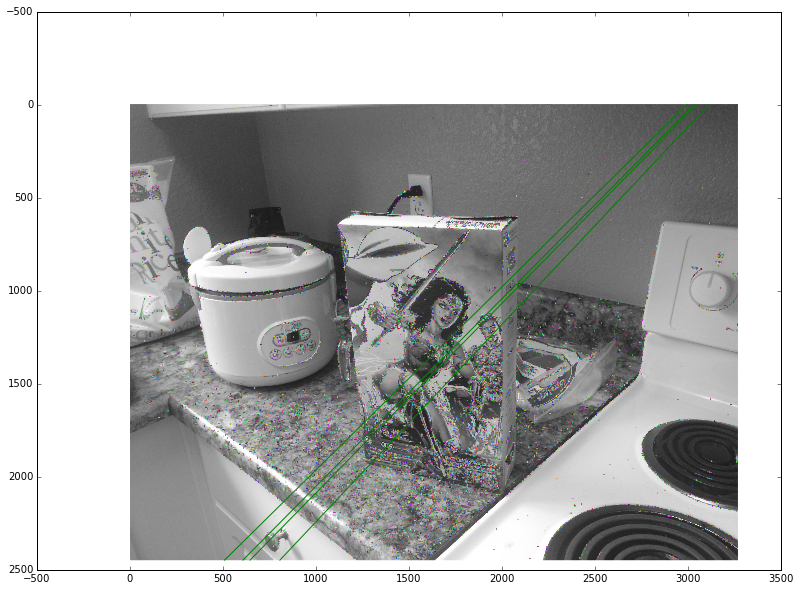

In [134]:
# grab 5 random points, and plot their epipolar lines for the right image
import random
points = random.sample(keypoints1, 5)
lines = []
for i in range(5):
    #generate epipolar lines for the points.
    lines.append(np.matmul([points[i].pt[0], points[i].pt[1], 1], F))
plt.imshow(road2)
ax = plt.gca()
for line in lines:
    plotLine(road2, line, "g")

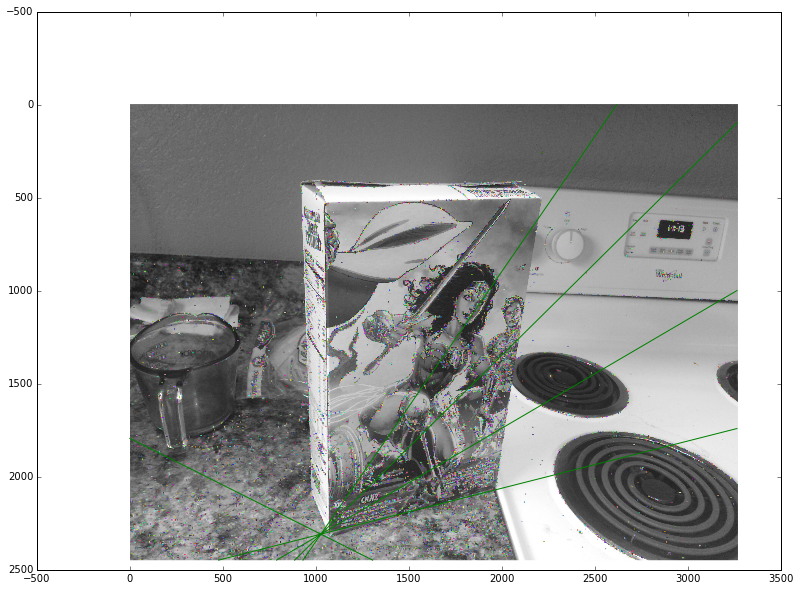

In [135]:
#grab 5 random points and plot their epipolar lines for the left image.
random.sample(keypoints2, 5)
lines = []
for i in range(5):
    #Generate lines for the 5 points
    lines.append(np.matmul(F, [points[i].pt[0], points[i].pt[1], 1]))
plt.imshow(road1)
ax = plt.gca()
for line in lines:
    plotLine(road1, line, "g")

In [136]:
# Perform RANSAC method
N = 100000
s = 8
currF = None
maxInliers = 0
for n in xrange(N):
    sampledMatches = random.sample(good, s)
    FToTest = computeF(sampledMatches, keypoints1, keypoints2)
    numIn = 0
    for match in good:
        p = keypoints1[match[0].queryIdx].pt
        q = keypoints2[match[0].trainIdx].pt
        if (abs(np.matmul([p[0], p[1], 1], np.matmul(FToTest, [q[0], q[1], 1])))) < .01:
            numIn += 1
    if numIn > maxInliers:
        maxInliers = numIn
        currF = FToTest
print(currF)
print(maxInliers)

[[  2.16596303e-07   5.55579947e-08  -4.45607091e-04]
 [  9.74979624e-08   4.41563628e-08  -2.34184208e-04]
 [ -4.79064661e-04  -1.31095496e-04   9.99999750e-01]]
477


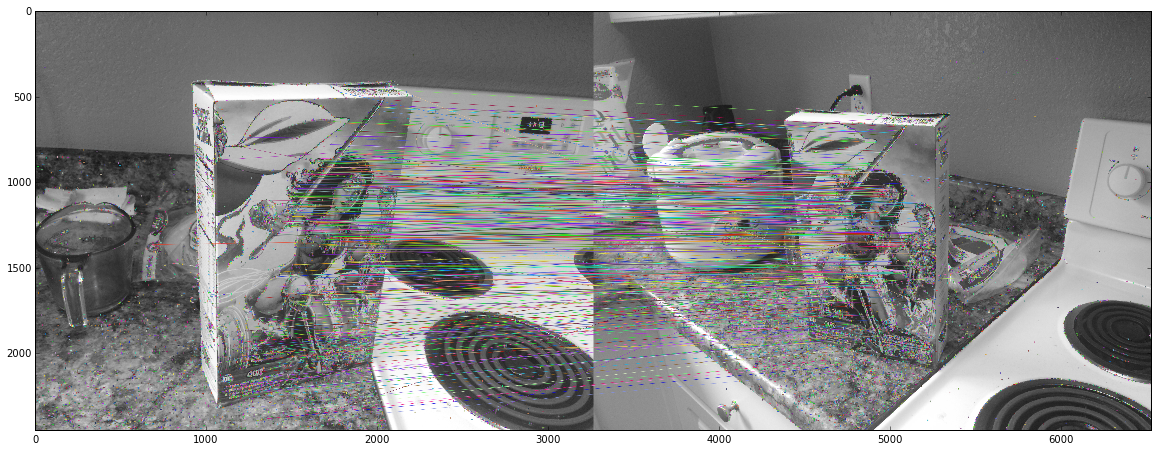

In [137]:
inlierSet = []
#calculate the final set of inliers
for match in good:
    p = keypoints1[match[0].queryIdx].pt
    q = keypoints2[match[0].trainIdx].pt
    if abs(np.matmul([p[0], p[1], 1], np.matmul(currF, [q[0], q[1], 1]))) < .01:
        inlierSet.append(match[0])
xl = [keypoints1[match.queryIdx] for match in inlierSet]
xr = [keypoints2[match.trainIdx] for match in inlierSet]
#recalculate fundamental matrix with all inliers.
A = []
for i in xrange(len(xl)):
    x = xl[i].pt
    x_prime = xr[i].pt
    A.append([x[0]*x_prime[0], x[1]*x_prime[0], x_prime[0],
            x[0]*x_prime[1], x[1]*x_prime[1], x_prime[1], x[0], x[1], 1])
A = np.array(A)
_, _, V = linalg.svd(A)
F = V[-1,:].reshape((3,3))
U, s, V = linalg.svd(F)
sigma = np.diag(s)
sigma[2,2] = 0
F = np.matmul(U, np.matmul(sigma, V))

#plot the inliers
drawInliers = map(lambda x: [x], inlierSet)
matchImg = cv2.drawMatchesKnn(road1, keypoints1, road2, keypoints2, drawInliers, None, flags=2)
plt.imshow(matchImg)

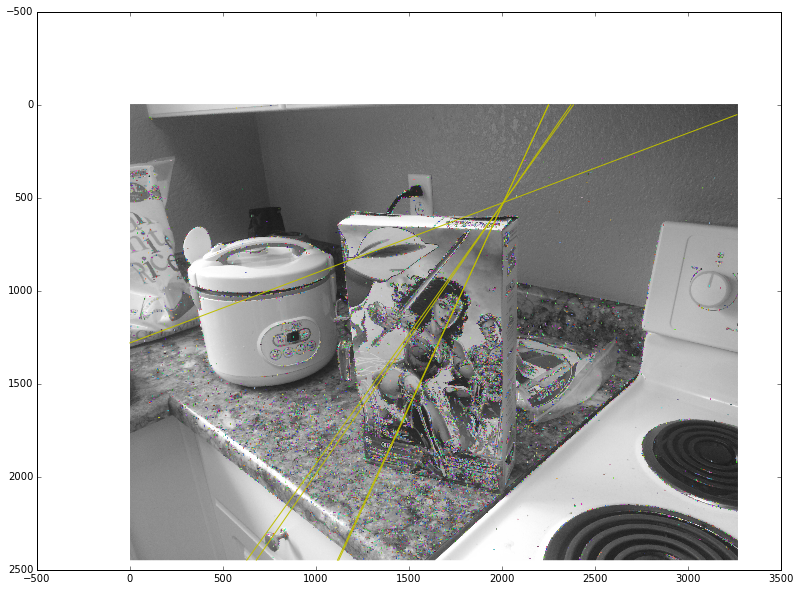

In [138]:
# grab 5 random points, and plot their epipolar lines for the right image
points = random.sample(keypoints1, 5)
lines = []
for i in range(5):
    lines.append(np.matmul([points[i].pt[0], points[i].pt[1], 1], F))
plt.imshow(road2)
ax = plt.gca()
for line in lines:
    plotLine(road2, line, "y")

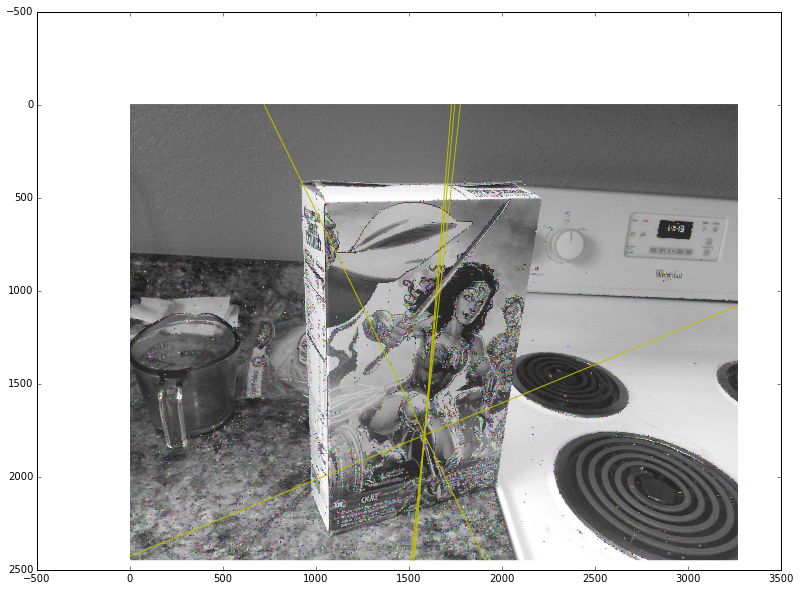

In [139]:
#grab 5 random points and plot their epipolar lines for the left image.
random.sample(keypoints2, 5)
lines = []
for i in range(5):
    lines.append(np.matmul(F, [points[i].pt[0], points[i].pt[1], 1]))
plt.imshow(road1)
ax = plt.gca()
for line in lines:
    plotLine(road1, line, "y")